In [1]:
from build import create_transform, create_model, create_dataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys, os, path
from pathlib import Path

sys.path.append(Path(os.getcwd()).parent.absolute().__str__())

In [3]:
from psbody.mesh import Mesh
from utils.landmarks import load_binary_pickle, load_embedding, tf_get_model_lmks, create_lmk_spheres

from tf_smpl.batch_smpl import SMPL
from ScipyOptimizerInterface import ScipyOptimizerInterface as scipy_pt

In [4]:
transform = create_transform()

dataset = create_dataset("../data/neutral_images/", transform=transform)

Loaded image: CFD-AF-200-228-N.jpg, len(images): 1
Loaded image: CFD-AF-201-060-N.jpg, len(images): 2
Loaded image: CFD-AF-202-122-N.jpg, len(images): 3
Loaded image: CFD-AF-203-077-N.jpg, len(images): 4
Loaded image: CFD-AF-204-067-N.jpg, len(images): 5
Loaded image: CFD-AF-205-155-N.jpg, len(images): 6
Loaded image: CFD-AF-206-079-N.jpg, len(images): 7
Loaded image: CFD-AF-207-023-N.jpg, len(images): 8
Loaded image: CFD-AF-208-003-N.jpg, len(images): 9
Loaded image: CFD-AF-209-006-N.jpg, len(images): 10
Loaded image: CFD-AF-210-050-N.jpg, len(images): 11
Loaded image: CFD-AF-211-066-N.jpg, len(images): 12
Loaded image: CFD-AF-212-097-N.jpg, len(images): 13
Loaded image: CFD-AF-213-126-N.jpg, len(images): 14
Loaded image: CFD-AF-214-139-N.jpg, len(images): 15
Loaded image: CFD-AF-215-70-N.jpg, len(images): 16
Loaded image: CFD-AF-216-106-N.jpg, len(images): 17
Loaded image: CFD-AF-217-155-N.jpg, len(images): 18
Loaded image: CFD-AF-218-157-N.jpg, len(images): 19
Loaded image: CFD-AF-2

In [5]:
model = create_model()

In [6]:
import tensorflow as tf

iterator = iter(dataset["images"])
next(iterator)

image = next(iterator).numpy()

input_image_orig = tf.expand_dims(image, 0)
output = model(input_image_orig)
print(output.shape)

(1, 418)


In [7]:
from my_utils import extract_flame_params

flame_params = extract_flame_params(output)
print(flame_params.keys())
print([value.shape for key, value in flame_params.items()])

dict_keys(['trans', 'rot', 'pose', 'shape', 'exp'])
[TensorShape([1, 3]), TensorShape([1, 3]), TensorShape([1, 12]), TensorShape([1, 300]), TensorShape([1, 100])]


In [8]:
from psbody.mesh import Mesh
from psbody.mesh.meshviewer import MeshViewer
from tf_smpl.batch_smpl import SMPL
import numpy as np
np.bool = bool

model_fname = '../models/generic_model.pkl'
smpl = SMPL(model_fname)

tf_trans = flame_params['trans']
tf_shape = flame_params['shape']
tf_exp = flame_params['exp']
tf_rot = flame_params['rot']
tf_pose = flame_params['pose']

tf_model = tf.squeeze(smpl(tf_trans, tf.concat([tf_shape, tf_exp], axis=-1), tf.concat([tf_rot, tf_pose], axis=-1)))

In [9]:
%%capture

sample_mesh = Mesh(tf_model, smpl.f)

out_fname = "test_from_jupyter.ply"
mv = MeshViewer()
mv.set_dynamic_meshes([sample_mesh], blocking=True)
sample_mesh.write_ply(out_fname)

In [10]:
import importlib

import my_utils
importlib.reload(my_utils)

from my_utils import render_mesh

In [11]:
rendered_images = render_mesh(out_fname)

In [12]:
rendered_images.shape

torch.Size([1, 512, 512, 4])

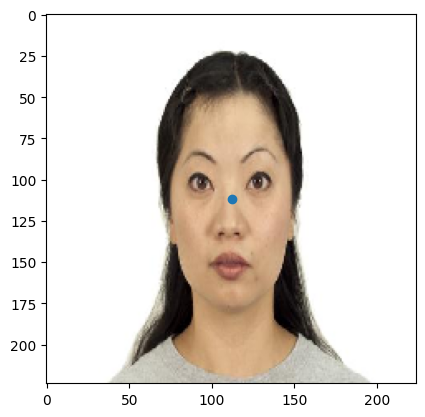

In [13]:
from matplotlib import pyplot as plt

from my_utils import crop_image

image = next(iter(dataset["images"])).numpy()

# input_cropped = crop_image(image * 255, top_only=True) / 255
plt.imshow(image)
width = image.shape[1]
height = image.shape[0]

plt.scatter(int(width) / 2, int(height) / 2)

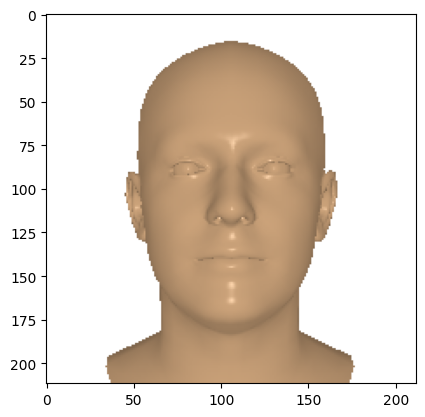

In [14]:
import cv2

horizontal_crop = 150

output_image = (rendered_images[0, horizontal_crop:-horizontal_crop, :, :3].numpy() * 255).astype(np.uint8)
width = output_image.shape[1]
height = output_image.shape[0]

vertical_crop = (width - height) // 2

output_image = output_image[:, vertical_crop: -vertical_crop]
from my_utils import crop_image
# output_cropped = crop_image(first_output_image)

# output_resized = cv2.resize(output_cropped, (input_cropped.shape[1], input_cropped.shape[0]))
plt.imshow(output_image)

(212, 212, 3) <class 'numpy.ndarray'>
rectangles[[(55, 56) (163, 163)]] <class '_dlib_pybind11.rectangles'>


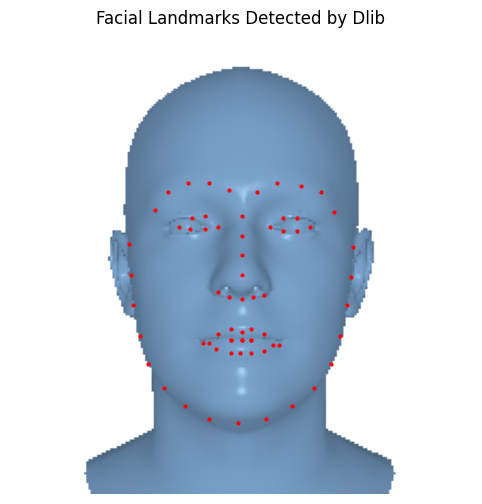

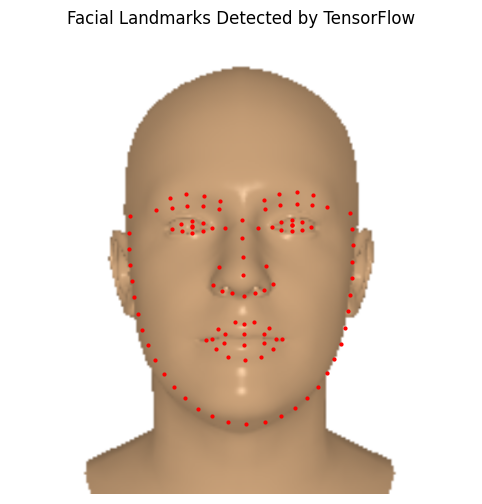

In [15]:
from my_utils import detect_face_landmarks_dlib
import keras
sys.path.append("Human-Face-Landmark-Detection-in-TensorFlow/")

model_path = os.path.join("../Human-Face-Landmark-Detection-in-TensorFlow", "files", "model.h5")
landmarks_model = keras.models.load_model(model_path)

_ = detect_face_landmarks_dlib(output_image, show=True)
from my_utils import detect_face_landmarks_tf

output_landmarks = detect_face_landmarks_tf(output_image, landmarks_model, show=True)

(212, 212, 3) <class 'numpy.ndarray'>
rectangles[[(71, 80) (146, 155)]] <class '_dlib_pybind11.rectangles'>


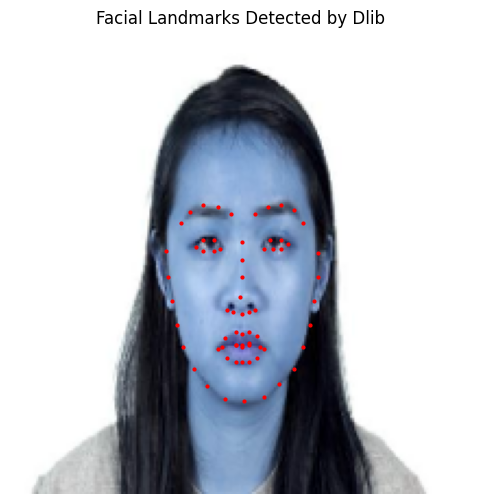

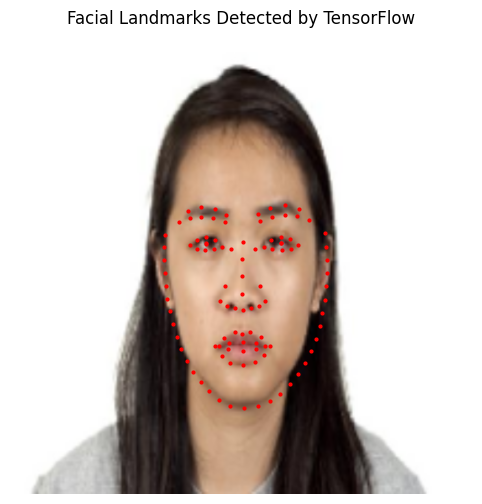

In [16]:
from my_utils import detect_face_landmarks_dlib, detect_face_landmarks_tf
input_image = cv2.resize(input_image_orig[0].numpy(), (output_image.shape[1], output_image.shape[0]))

_ = detect_face_landmarks_dlib(input_image, show=True)

input_landmarks = detect_face_landmarks_tf(input_image, landmarks_model, show=True)

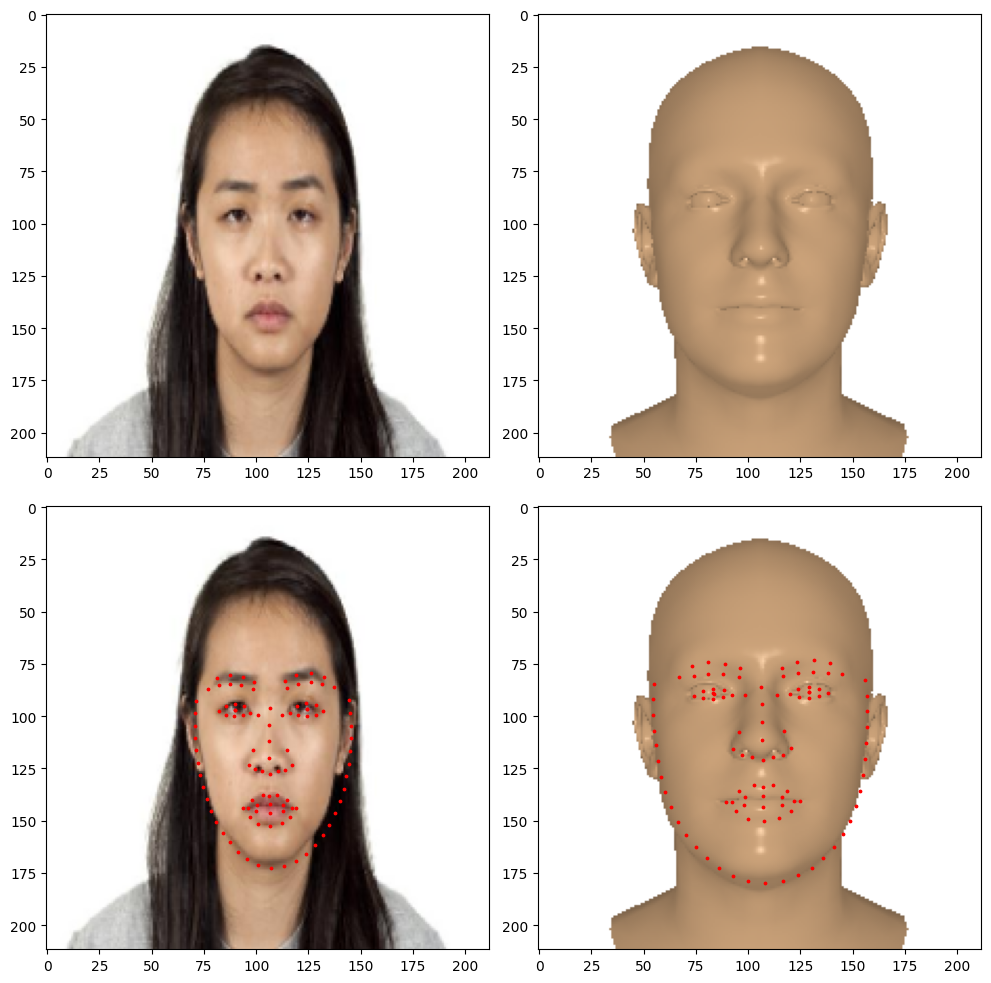

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

input_image_show = input_image
output_image_show = output_image

axs[0][0].imshow(input_image_show)
axs[0][1].imshow(output_image_show)

axs[1][0].imshow(input_image_show)
axs[1][1].imshow(output_image_show)

axs[1][0].scatter(*input_landmarks, s=3, color='r')
axs[1][1].scatter(*output_landmarks, s=3, color='r')

plt.tight_layout()

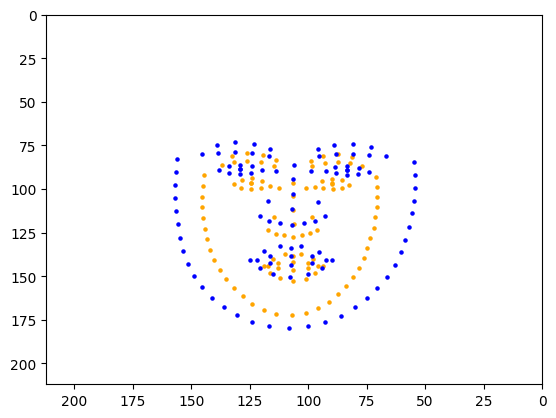

In [18]:
plt.scatter(input_landmarks[0], input_landmarks[1], s=5, color='orange')
plt.scatter(output_landmarks[0], output_landmarks[1], s=5, color='blue')

plt.xlim(0, input_image.shape[1])
plt.ylim(0, input_image.shape[0])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [19]:
from keras.losses import MeanSquaredError as mse

mse_loss = mse()

loss = mse_loss(input_landmarks, output_landmarks)
print(loss)

tf.Tensor(47.541378, shape=(), dtype=float32)


In [20]:
import tensorflow as tf
import tensorflow_graphics as tfg
from tensorflow_graphics.geometry.transformation import look_at
from tensorflow_graphics.rendering.camera import perspective

In [74]:
import open3d as o3d

mesh = o3d.io.read_triangle_mesh(out_fname)
mesh.compute_vertex_normals()

TriangleMesh with 5023 points and 9976 triangles.